# First NoteBook Script - Showing Live Orders Placed

# Connect to MetaTrader 5


In [1]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5

# Connect to the MetaTrader5 terminal
if not mt5.initialize():
    print("Failed to initialize MetaTrader5")
    mt5.shutdown()
else:
    print("MetaTrader5 initialized successfully")

MetaTrader5 initialized successfully


# Retrieve Historical Price Data

In [3]:
# Specify the symbol and timeframe
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1  # 1-hour timeframe

# Retrieve historical price data
print("Retrieving historical price data...")
num_bars = 1000  # Number of bars to retrieve
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(rates, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])
df['time'] = pd.to_datetime(df['time'], unit='s')

# Print the historical price data
print("Historical Price Data:")
print(df.head())

Retrieving historical price data...
Historical Price Data:
                 time     open     high      low    close  tick_volume  \
0 2024-03-26 05:00:00  1.08426  1.08441  1.08358  1.08369          682   
1 2024-03-26 06:00:00  1.08369  1.08410  1.08364  1.08401          678   
2 2024-03-26 07:00:00  1.08401  1.08481  1.08397  1.08471          871   
3 2024-03-26 08:00:00  1.08471  1.08519  1.08463  1.08506         1051   
4 2024-03-26 09:00:00  1.08507  1.08528  1.08397  1.08422         1770   

   spread  real_volume  
0       0            0  
1       0            0  
2       0            0  
3       0            0  
4       0            0  


# Calculate Indicators


In [56]:
# Implement the Wavy Tunnel and long-term EMA
def ema(data, period):
    ema_values = [None] * (period - 1)  # Initialize with None for the first period - 1 values
    sma = sum(data[:period]) / period
    ema_values.append(sma)
    multiplier = 2 / (period + 1)
    
    for price in data[period:]:
        ema = (price - ema_values[-1]) * multiplier + ema_values[-1]
        ema_values.append(ema)
    
    return ema_values

# User inputs
apply_threshold = True
threshold_values = {
    'USD': 2,
    'EUR': 2,
    'JPY': 300,
    'GBP': 6,
    'CHF': 2,
    'AUD': 2,
    'default': 100
}

# Wavy Tunnel
print("Calculating Wavy Tunnel indicator...")
df['wavy_h'] = ema(df['high'], 34)
df['wavy_c'] = ema(df['close'], 34)
df['wavy_l'] = ema(df['low'], 34)
df['tunnel1'] = ema(df['close'], 144)
df['tunnel2'] = ema(df['close'], 169)

# Print each Wavy Tunnel column
print("Wavy Tunnel High (wavy_h):")
print(df[['time', 'high', 'wavy_h']])
print("\nWavy Tunnel Close (wavy_c):")
print(df[['time', 'close', 'wavy_c']])
print("\nWavy Tunnel Low (wavy_l):")
print(df[['time', 'low', 'wavy_l']])
print("\nTunnel 1:")
print(df[['time', 'close', 'tunnel1']])
print("\nTunnel 2:")
print(df[['time', 'close', 'tunnel2']])

# Implement long-term EMA
print("Calculating long-term EMA...")
df['long_term_ema'] = ema(df['close'], 200)

# Print the DataFrame with long-term EMA
print("DataFrame with long-term EMA:")
print(df[['time', 'close', 'long_term_ema']])

Calculating Wavy Tunnel indicator...
Wavy Tunnel High (wavy_h):
                   time     high    wavy_h
0   2024-03-01 13:00:00  1.08191       NaN
1   2024-03-01 14:00:00  1.08248       NaN
2   2024-03-01 15:00:00  1.08155       NaN
3   2024-03-01 16:00:00  1.08207       NaN
4   2024-03-01 17:00:00  1.08418       NaN
..                  ...      ...       ...
995 2024-04-30 03:00:00  1.07177  1.072063
996 2024-04-30 04:00:00  1.07178  1.072047
997 2024-04-30 05:00:00  1.07073  1.071972
998 2024-04-30 06:00:00  1.07072  1.071900
999 2024-04-30 07:00:00  1.07057  1.071824

[1000 rows x 3 columns]

Wavy Tunnel Close (wavy_c):
                   time    close    wavy_c
0   2024-03-01 13:00:00  1.08183       NaN
1   2024-03-01 14:00:00  1.08129       NaN
2   2024-03-01 15:00:00  1.08128       NaN
3   2024-03-01 16:00:00  1.07999       NaN
4   2024-03-01 17:00:00  1.08351       NaN
..                  ...      ...       ...
995 2024-04-30 03:00:00  1.07150  1.071499
996 2024-04-30 04:00:0

# Detect Peaks and Dips

In [70]:
# Implement peak and dip detection
def detect_peaks_and_dips(df, peak_type):
    peaks = []
    dips = []
    for i in range(len(df)):
        is_peak = True
        is_dip = True
        for j in range(peak_type):
            start_index = max(0, i - j)
            end_index = min(len(df) - 1, i + j)
            if df['high'][i] <= df['high'][start_index] or df['high'][i] <= df['high'][end_index]:
                is_peak = False
            if df['low'][i] >= df['low'][start_index] or df['low'][i] >= df['low'][end_index]:
                is_dip = False
        if is_peak:
            peaks.append(df['high'][i])
        if is_dip:
            dips.append(df['low'][i])
    return peaks, dips
print("Detecting peaks and dips...")
peaks, dips = detect_peaks_and_dips(df, peak_type)

# Print the peaks and dips
print("Peaks:")
for peak in peaks:
    print(peak)

print("\nDips:")
for dip in dips:
    print(dip)

Detecting peaks and dips...
Peaks:

Dips:


# Generate Entry Signals

In [58]:
## Implement entry conditions
def check_entry_conditions(row):
    buy_condition = (
        row['close'] > max(row['wavy_c'], row['wavy_h'], row['wavy_l']) and
        min(row['wavy_c'], row['wavy_h'], row['wavy_l']) > max(row['tunnel1'], row['tunnel2'])
    )
    sell_condition = (
        row['close'] < min(row['wavy_c'], row['wavy_h'], row['wavy_l']) and
        max(row['wavy_c'], row['wavy_h'], row['wavy_l']) < min(row['tunnel1'], row['tunnel2'])
    )

    if apply_threshold:
        threshold = threshold_values.get(symbol[:3], threshold_values['default']) * mt5.symbol_info(symbol).trade_tick_size
        buy_condition &= row['close'] > max(row['wavy_c'], row['wavy_h'], row['wavy_l']) + threshold
        sell_condition &= row['close'] < min(row['wavy_c'], row['wavy_h'], row['wavy_l']) - threshold

    return buy_condition, sell_condition

df['buy_signal'], df['sell_signal'] = zip(*df.apply(check_entry_conditions, axis=1))

# Print the entry signals
print("Checking entry conditions...")
print("Entry Signals:")
print(df[['time', 'close', 'buy_signal', 'sell_signal']])

# Showcase the buy and sell signals
def print_signals(df):
    buy_signals = df[df['buy_signal'] == True]
    sell_signals = df[df['sell_signal'] == True]
    
    print("Buy Signals:")
    print(buy_signals[['time', 'close', 'buy_signal']])
    
    print("\nSell Signals:")
    print(sell_signals[['time', 'close', 'sell_signal']])

print_signals(df)

Checking entry conditions...
Entry Signals:
                   time    close  buy_signal  sell_signal
0   2024-03-01 13:00:00  1.08183       False        False
1   2024-03-01 14:00:00  1.08129       False        False
2   2024-03-01 15:00:00  1.08128       False        False
3   2024-03-01 16:00:00  1.07999       False        False
4   2024-03-01 17:00:00  1.08351       False        False
..                  ...      ...         ...          ...
995 2024-04-30 03:00:00  1.07150       False        False
996 2024-04-30 04:00:00  1.07071       False        False
997 2024-04-30 05:00:00  1.07065       False        False
998 2024-04-30 06:00:00  1.07053       False        False
999 2024-04-30 07:00:00  1.07047       False        False

[1000 rows x 4 columns]
Buy Signals:
                   time    close  buy_signal
144 2024-03-11 13:00:00  1.09429        True
159 2024-03-12 04:00:00  1.09361        True
160 2024-03-12 05:00:00  1.09361        True
161 2024-03-12 06:00:00  1.09366        Tr

# Plotting

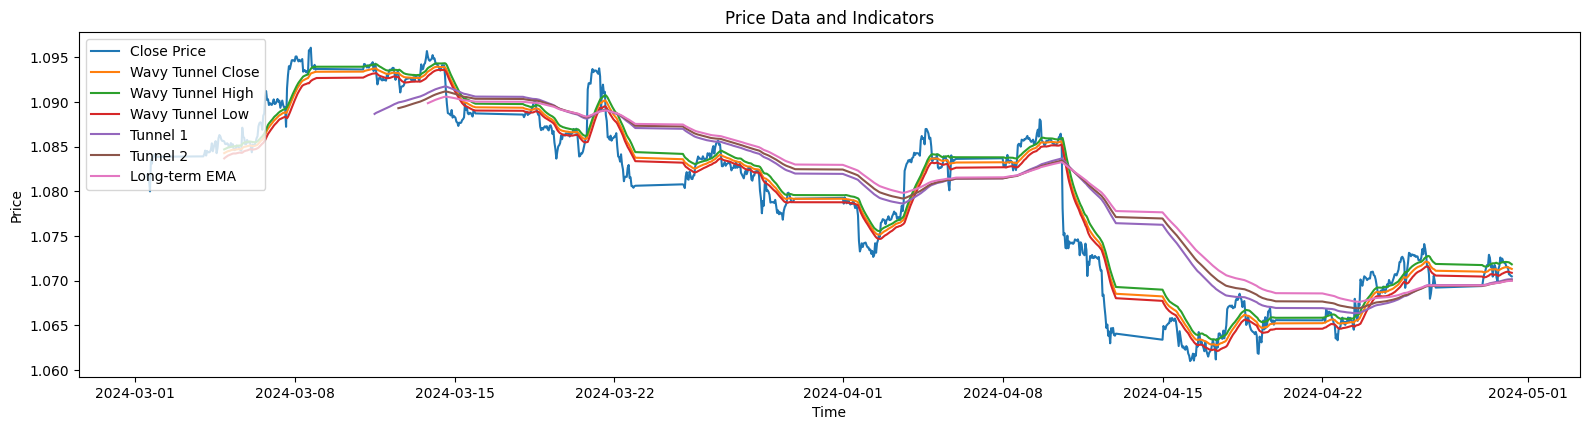

In [67]:
import matplotlib.pyplot as plt

# Plotting the price data and indicators
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(df['time'], df['close'], label='Close Price')
plt.plot(df['time'], df['wavy_c'], label='Wavy Tunnel Close')
plt.plot(df['time'], df['wavy_h'], label='Wavy Tunnel High')
plt.plot(df['time'], df['wavy_l'], label='Wavy Tunnel Low')
plt.plot(df['time'], df['tunnel1'], label='Tunnel 1')
plt.plot(df['time'], df['tunnel2'], label='Tunnel 2')
plt.plot(df['time'], df['long_term_ema'], label='Long-term EMA')
plt.legend(loc='upper left')
plt.title('Price Data and Indicators')
plt.xlabel('Time')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

# Check Support and Resistance Proximity

In [60]:
# Implement support and resistance proximity
def sma(data, period):
    sma_values = []
    for i in range(len(data)):
        if i < period or None in data[i - period + 1: i + 1]:
            sma_values.append(None)
        else:
            sma_values.append(sum(filter(None, data[i - period + 1: i + 1])) / period)
    return sma_values

def min_low(low_data, period):
    min_low_values = []
    for i in range(len(low_data)):
        if i < period:
            min_low_values.append(None)
        else:
            min_low_values.append(min(low_data[i - period + 1: i + 1]))
    return min_low_values

def max_high(high_data, period):
    max_high_values = []
    for i in range(len(high_data)):
        if i < period:
            max_high_values.append(None)
        else:
            max_high_values.append(max(high_data[i - period + 1: i + 1]))
    return max_high_values

def check_support_resistance_proximity(row):
    support_level = sma(min_low(df['low'], 18), 5)
    resistance_level = sma(max_high(df['high'], 18), 5)
    proximity_threshold = 0.01  # Adjust this value based on user input
    
    if support_level[-1] is not None:
        near_support = row['close'] <= support_level[-1] * (1 + proximity_threshold)
    else:
        near_support = False
    
    if resistance_level[-1] is not None:
        near_resistance = row['close'] >= resistance_level[-1] * (1 - proximity_threshold)
    else:
        near_resistance = False
    
    return near_support, near_resistance

print("Checking support and resistance proximity...")
df['near_support'], df['near_resistance'] = zip(*df.apply(check_support_resistance_proximity, axis=1))

print("Support and Resistance Proximity:")
print(df[['time', 'close', 'near_support', 'near_resistance']])

Checking support and resistance proximity...
Support and Resistance Proximity:
                   time    close  near_support  near_resistance
0   2024-03-01 13:00:00  1.08183         False             True
1   2024-03-01 14:00:00  1.08129         False             True
2   2024-03-01 15:00:00  1.08128         False             True
3   2024-03-01 16:00:00  1.07999         False             True
4   2024-03-01 17:00:00  1.08351         False             True
..                  ...      ...           ...              ...
995 2024-04-30 03:00:00  1.07150          True             True
996 2024-04-30 04:00:00  1.07071          True             True
997 2024-04-30 05:00:00  1.07065          True             True
998 2024-04-30 06:00:00  1.07053          True             True
999 2024-04-30 07:00:00  1.07047          True             True

[1000 rows x 4 columns]


# Implement Risk Management and Position Sizing

In [62]:
# User inputs
min_auto_tp_threshold_values = {
    'USD': 5,
    'EUR': 10,
    'JPY': 100,
    'GBP': 50,
    'CHF': 5,
    'AUD': 5,
    'default': 100
}

last_tp_limit_values = {
    'USD': 15,
    'EUR': 10,
    'JPY': 800,
    'GBP': 60,
    'CHF': 15,
    'AUD': 15,
    'default': 250
}

enable_second_strategy = True
min_gap_second_values = {
    'USD': 15,
    'EUR': 15,
    'JPY': 650,
    'GBP': 50,
    'CHF': 15,
    'AUD': 15,
    'default': 650
}

max_allow_into_zone = 0.25

# Risk management and position sizing
risk_percent = 0.02  # Adjust this value based on your risk tolerance
account_balance = mt5.account_info().balance

def calculate_position_size(price):
    risk_amount = account_balance * risk_percent
    position_size = risk_amount / (price * mt5.symbol_info(symbol).trade_tick_size)
    return position_size

# Order Management and Position Execution

In [64]:
# Order management
def open_position(signal_type, price):
    if signal_type == "buy":
        lot_size = calculate_position_size(price)
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot_size,
            "type": mt5.ORDER_TYPE_BUY,
            "price": price,
            "magic": 12345,
            "comment": "Python Buy Order",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        result = mt5.order_send(request)
        print(f"Buy Order Sent: {result}")
    
    elif signal_type == "sell":
        lot_size = calculate_position_size(price)
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot_size,
            "type": mt5.ORDER_TYPE_SELL,
            "price": price,
            "magic": 12345,
            "comment": "Python Sell Order",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        result = mt5.order_send(request)
        print(f"Sell Order Sent: {result}")

def close_positions():
    positions = mt5.positions_get(symbol=symbol)
    for position in positions:
        if position.type == mt5.POSITION_TYPE_BUY:
            close_request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": position.volume,
                "type": mt5.ORDER_TYPE_SELL,
                "position": position.ticket,
                "price": mt5.symbol_info_tick(symbol).bid,
                "magic": 12345,
                "comment": "Python Close Buy Order",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
                }
            result = mt5.order_send(close_request)
            print(f"Closed Buy Position: {result}")
        elif position.type == mt5.POSITION_TYPE_SELL:
            close_request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": position.volume,
                "type": mt5.ORDER_TYPE_BUY,
                "position": position.ticket,
                "price": mt5.symbol_info_tick(symbol).ask,
                "magic": 12345,
                "comment": "Python Close Sell Order",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
              }
            result = mt5.order_send(close_request)
            print(f"Closed Sell Position: {result}")

# Position Execution and Final Output

In [66]:
# Print the positions to take
def print_positions(df):
    buy_signals = df[df['buy_signal'] == True]
    sell_signals = df[df['sell_signal'] == True]
    
    print("Positions to take:")
    
    for index, row in buy_signals.iterrows():
        print(f"Buy {symbol} at {row['close']}")
        open_position("buy", row['close'])
    
    for index, row in sell_signals.iterrows():
        print(f"Sell {symbol} at {row['close']}")
        open_position("sell", row['close'])

print_positions(df)
close_positions()

Positions to take:
Buy EURUSD at 1.09429
Buy Order Sent: OrderSendResult(retcode=10014, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Invalid volume', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=12345, order=0, symbol='EURUSD', volume=18276690.8223597, price=1.09429, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=0, type_filling=1, type_time=0, expiration=0, comment='Python Buy Order', position=0, position_by=0))
Buy EURUSD at 1.09361
Buy Order Sent: OrderSendResult(retcode=10014, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Invalid volume', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=12345, order=0, symbol='EURUSD', volume=18288055.156774353, price=1.09361, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=0, type_filling=1, type_time=0, expiration=0, comment='Python Buy Order', position=0, position_by=0))
Buy EURUSD at 1.09361
Buy Order Sent: OrderSendResult(retcode=10014, deal=0, order=

# Second Jupyter Notebook Script with Back Testing

MetaTrader5 initialized successfully
Historical Price Data:
                 time     open     high      low    close  tick_volume  \
0 2024-03-01 14:00:00  1.08184  1.08248  1.08118  1.08129         7302   
1 2024-03-01 15:00:00  1.08127  1.08155  1.08077  1.08128         8592   
2 2024-03-01 16:00:00  1.08128  1.08207  1.07979  1.07999         9580   
3 2024-03-01 17:00:00  1.08009  1.08418  1.08009  1.08351        17880   
4 2024-03-01 18:00:00  1.08350  1.08369  1.08231  1.08309         8778   

   spread  real_volume  
0       0            0  
1       0            0  
2       0            0  
3       0            0  
4       0            0  
Wavy Tunnel:
                 time     high      low    close  wavy_h  wavy_c  wavy_l  \
0 2024-03-01 14:00:00  1.08248  1.08118  1.08129     NaN     NaN     NaN   
1 2024-03-01 15:00:00  1.08155  1.08077  1.08128     NaN     NaN     NaN   
2 2024-03-01 16:00:00  1.08207  1.07979  1.07999     NaN     NaN     NaN   
3 2024-03-01 17:00:00  1.084

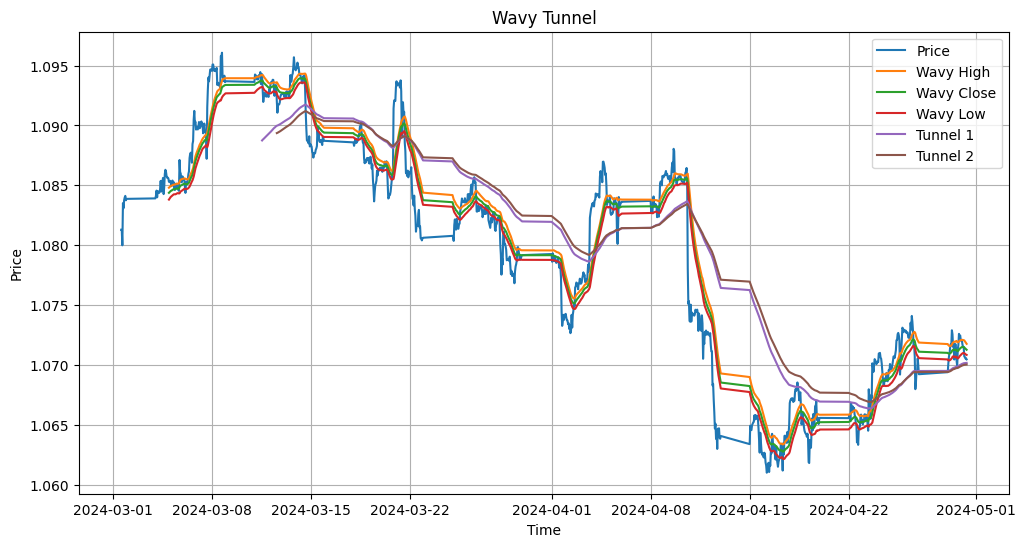

In [72]:
# Importing required libraries
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt

# Connecting to the MetaTrader5 terminal
if not mt5.initialize():
    print("Failed to initialize MetaTrader5")
    mt5.shutdown()
else:
    print("MetaTrader5 initialized successfully")

# Specifying the symbol and timeframe
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1  # 1-hour timeframe

# Retrieving historical price data
num_bars = 1000  # Number of bars to retrieve
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)

# Converting the data to a pandas DataFrame
df = pd.DataFrame(rates, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])
df['time'] = pd.to_datetime(df['time'], unit='s')

# Printing the DataFrame
print("Historical Price Data:")
print(df.head())

# Implementing the Wavy Tunnel and other indicators
def ema(data, period):
    ema_values = [None] * (period - 1)  # Initialize with None for the first period - 1 values
    sma = sum(data[:period]) / period
    ema_values.append(sma)
    multiplier = 2 / (period + 1)
    
    for price in data[period:]:
        ema = (price - ema_values[-1]) * multiplier + ema_values[-1]
        ema_values.append(ema)
    
    return ema_values

# Wavy Tunnel
df['wavy_h'] = ema(df['high'], 34)
df['wavy_c'] = ema(df['close'], 34)
df['wavy_l'] = ema(df['low'], 34)
df['tunnel1'] = ema(df['close'], 144)
df['tunnel2'] = ema(df['close'], 169)

# Printing the Wavy Tunnel columns
print("Wavy Tunnel:")
print(df[['time', 'high', 'low', 'close', 'wavy_h', 'wavy_c', 'wavy_l', 'tunnel1', 'tunnel2']].head())

# Plotting the Wavy Tunnel
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label='Price')
plt.plot(df['time'], df['wavy_h'], label='Wavy High')
plt.plot(df['time'], df['wavy_c'], label='Wavy Close')
plt.plot(df['time'], df['wavy_l'], label='Wavy Low')
plt.plot(df['time'], df['tunnel1'], label='Tunnel 1')
plt.plot(df['time'], df['tunnel2'], label='Tunnel 2')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Wavy Tunnel')
plt.legend()
plt.grid(True)
plt.show()

# Inputs and Entry conditions

In [73]:
# Implementing user inputs
apply_threshold = True
threshold_values = {
    'USD': 2,
    'EUR': 2,
    'JPY': 300,
    'GBP': 6,
    'CHF': 2,
    'AUD': 2,
    'default': 100
}

# Liquidation level threshold
min_auto_tp_threshold_values = {
    'USD': 5,
    'EUR': 10,
    'JPY': 100,
    'GBP': 50,
    'CHF': 5,
    'AUD': 5,
    'default': 100
}

# Last take profit limit
last_tp_limit_values = {
    'USD': 15,
    'EUR': 10,
    'JPY': 800,
    'GBP': 60,
    'CHF': 15,
    'AUD': 15,
    'default': 250
}

peak_type = 21

enable_second_strategy = True
min_gap_second_values = {
    'USD': 15,
    'EUR': 15,
    'JPY': 650,
    'GBP': 50,
    'CHF': 15,
    'AUD': 15,
    'default': 650
}

max_allow_into_zone = 0.25

is_range = False
from_date = '2024-02-01'
to_date = '2024-03-16'

is_proximity = True
support_resistance_proximity = 0.01

# Implementing peak and dip detection
def detect_peaks_and_dips(df, peak_type):
    peaks = []
    dips = []
    for i in range(len(df)):
        if i < peak_type or i >= len(df) - peak_type:
            continue
        is_peak = True
        is_dip = True
        for j in range(peak_type):
            if df['high'][i] <= df['high'][i-j] or df['high'][i] <= df['high'][i+j]:
                is_peak = False
            if df['low'][i] >= df['low'][i-j] or df['low'][i] >= df['low'][i+j]:
                is_dip = False
        if is_peak:
            peaks.append(df['high'][i])
        if is_dip:
            dips.append(df['low'][i])
    return peaks, dips

peak_type = 21
peaks, dips = detect_peaks_and_dips(df, peak_type)

print("Peaks:")
print(peaks[:5])
print("Dips:")
print(dips[:5])

# Implementing liquidation levels
def find_last_peak_dip(peaks, dips, current_price, min_threshold):
    last_peak = np.nan
    last_dip = np.nan
    for peak in reversed(peaks):
        if peak > current_price + min_threshold:
            last_peak = peak
            break
    for dip in reversed(dips):
        if dip < current_price - min_threshold:
            last_dip = dip
            break
    return last_peak, last_dip

min_threshold = 100  # Adjust this value based on the user input

# Implementing entry conditions
def check_entry_conditions(row, peaks, dips):
    buy_condition = (
        row['close'] > max(row['wavy_c'], row['wavy_h'], row['wavy_l']) and
        min(row['wavy_c'], row['wavy_h'], row['wavy_l']) > max(row['tunnel1'], row['tunnel2']) and
        row['close'] in peaks  # Check if the current close price is a peak
    )
    sell_condition = (
        row['close'] < min(row['wavy_c'], row['wavy_h'], row['wavy_l']) and
        max(row['wavy_c'], row['wavy_h'], row['wavy_l']) < min(row['tunnel1'], row['tunnel2']) and
        row['close'] in dips  # Check if the current close price is a dip
    )

    if apply_threshold:
        threshold = threshold_values.get(symbol[:3], threshold_values['default']) * mt5.symbol_info(symbol).trade_tick_size
        buy_condition &= row['close'] > max(row['wavy_c'], row['wavy_h'], row['wavy_l']) + threshold
        sell_condition &= row['close'] < min(row['wavy_c'], row['wavy_h'], row['wavy_l']) - threshold

    return buy_condition, sell_condition

df['buy_signal'], df['sell_signal'] = zip(*df.apply(lambda x: check_entry_conditions(x, peaks, dips), axis=1))

print("Entry Signals:")
print(df[['time', 'close', 'buy_signal', 'sell_signal']].head())

Peaks:
[]
Dips:
[]
Entry Signals:
                 time    close  buy_signal  sell_signal
0 2024-03-01 14:00:00  1.08129       False        False
1 2024-03-01 15:00:00  1.08128       False        False
2 2024-03-01 16:00:00  1.07999       False        False
3 2024-03-01 17:00:00  1.08351       False        False
4 2024-03-01 18:00:00  1.08309       False        False


# Back Testing and Results

Support and Resistance Proximity:
                 time    close  near_support  near_resistance
0 2024-03-01 14:00:00  1.08129         False             True
1 2024-03-01 15:00:00  1.08128         False             True
2 2024-03-01 16:00:00  1.07999         False             True
3 2024-03-01 17:00:00  1.08351         False             True
4 2024-03-01 18:00:00  1.08309         False             True
Initial Balance: 10000
Final Balance: 10000
Profit: 0


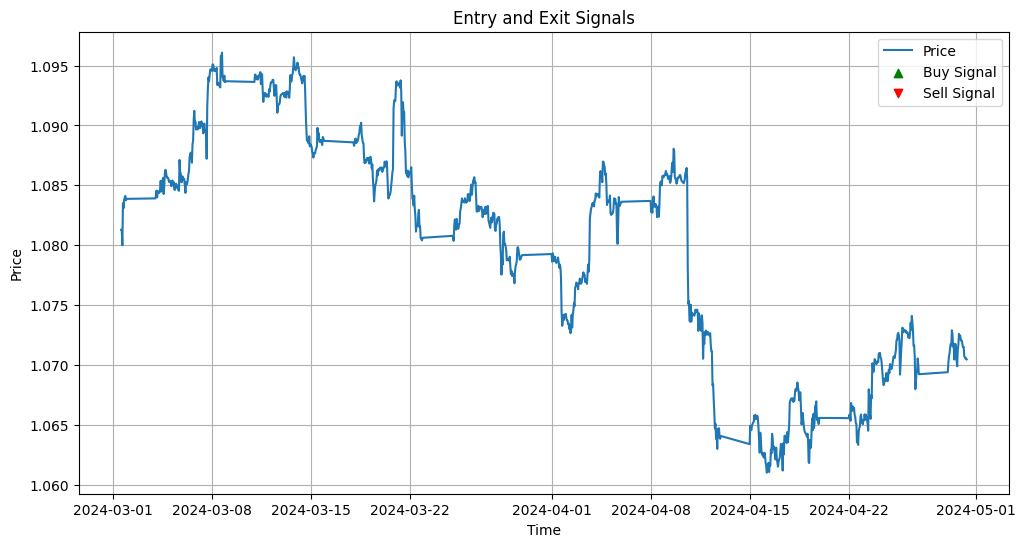

MetaTrader5 disconnected


In [74]:
# Implementing support and resistance proximity
def sma(data, period):
    sma_values = []
    for i in range(len(data)):
        if i < period or None in data[i - period + 1: i + 1]:
            sma_values.append(None)
        else:
            sma_values.append(sum(filter(None, data[i - period + 1: i + 1])) / period)
    return sma_values

def min_low(low_data, period):
    min_low_values = []
    for i in range(len(low_data)):
        if i < period:
            min_low_values.append(None)
        else:
            min_low_values.append(min(low_data[i - period + 1: i + 1]))
    return min_low_values

def max_high(high_data, period):
    max_high_values = []
    for i in range(len(high_data)):
        if i < period:
            max_high_values.append(None)
        else:
            max_high_values.append(max(high_data[i - period + 1: i + 1]))
    return max_high_values

def check_support_resistance_proximity(row):
    support_level = sma(min_low(df['low'], 18), 5)
    resistance_level = sma(max_high(df['high'], 18), 5)
    proximity_threshold = 0.01  # Adjust this value based on user input
    
    if support_level[-1] is not None:
        near_support = row['close'] <= support_level[-1] * (1 + proximity_threshold)
    else:
        near_support = False
    
    if resistance_level[-1] is not None:
        near_resistance = row['close'] >= resistance_level[-1] * (1 - proximity_threshold)
    else:
        near_resistance = False
    
    return near_support, near_resistance

df['near_support'], df['near_resistance'] = zip(*df.apply(check_support_resistance_proximity, axis=1))

print("Support and Resistance Proximity:")
print(df[['time', 'close', 'near_support', 'near_resistance']].head())

# Implementing position management
def calculate_position_size(row):
    balance = mt5.account_info().balance
    risk_percent = 0.01  # Adjust this value based on user input
    position_size = (balance * risk_percent) / (row['close'] * mt5.symbol_info(symbol).trade_tick_size)
    return position_size

def open_position(row):
    if row['buy_signal'] and not row['near_resistance']:
        lot_size = calculate_position_size(row)
        last_peak, _ = find_last_peak_dip(peaks, dips, row['close'], min_threshold)
        stop_loss = last_peak - (row['close'] - last_peak) * 1.5  # Set stop-loss level based on last peak
        take_profit = row['close'] + (row['close'] - last_peak) * 2  # Set take-profit level based on last peak
        
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot_size,
            "type": mt5.ORDER_TYPE_BUY,
            "price": row['close'],
            "sl": stop_loss,  # Set stop-loss price
            "tp": take_profit,  # Set take-profit price
            "magic": 12345,
            "comment": "Python Buy Order",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        result = mt5.order_send(request)
        print(f"Buy Order Sent: {result}")
    
    elif row['sell_signal'] and not row['near_support']:
        lot_size = calculate_position_size(row)
        _, last_dip = find_last_peak_dip(peaks, dips, row['close'], min_threshold)
        stop_loss = last_dip + (last_dip - row['close']) * 1.5  # Set stop-loss level based on last dip
        take_profit = row['close'] - (last_dip - row['close']) * 2  # Set take-profit level based on last dip
        
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot_size,
            "type": mt5.ORDER_TYPE_SELL,
            "price": row['close'],
            "sl": stop_loss,  # Set stop-loss price
            "tp": take_profit,  # Set take-profit price
            "magic": 12345,
            "comment": "Python Sell Order",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        result = mt5.order_send(request)
        print(f"Sell Order Sent: {result}")

def close_positions():
    positions = mt5.positions_get(symbol=symbol)
    for position in positions:
        if position.type == mt5.POSITION_TYPE_BUY:
            close_request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": position.volume,
                "type": mt5.ORDER_TYPE_SELL,
                "position": position.ticket,
                "price": mt5.symbol_info_tick(symbol).bid,
                "magic": 12345,
                "comment": "Python Close Buy Order",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }
            result = mt5.order_send(close_request)
            print(f"Closed Buy Position: {result}")
        
        elif position.type == mt5.POSITION_TYPE_SELL:
            close_request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": position.volume,
                "type": mt5.ORDER_TYPE_BUY,
                "position": position.ticket,
                "price": mt5.symbol_info_tick(symbol).ask,
                "magic": 12345,
                "comment": "Python Close Sell Order",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }
            result = mt5.order_send(close_request)
            print(f"Closed Sell Position: {result}")

# Implementing the second strategy
def check_second_strategy_conditions(row):
    fully_crossed_above = (
        row['close'] > max(row['wavy_c'], row['wavy_h'], row['wavy_l']) and
        row['close'] < min(row['tunnel1'], row['tunnel2'])
    )
    fully_crossed_below = (
        row['close'] < min(row['wavy_c'], row['wavy_h'], row['wavy_l']) and
        row['close'] > max(row['tunnel1'], row['tunnel2'])
    )
    return fully_crossed_above, fully_crossed_below

df['second_buy_signal'], df['second_sell_signal'] = zip(*df.apply(check_second_strategy_conditions, axis=1))

# Implementing backtesting and visualization
initial_balance = 10000
balance = initial_balance
position = None
trades = []

for _, row in df.iterrows():
    if position is None:
        if row['buy_signal']:
            position = 'long'
            entry_price = row['close']
            entry_time = row['time']
            lot_size = calculate_position_size(row)
            balance -= lot_size * entry_price
            trades.append(('buy', entry_time, entry_price, lot_size))
            open_position(row)  # Open a buy position
        elif row['sell_signal']:
            position = 'short'
            entry_price = row['close']
            entry_time = row['time']
            lot_size = calculate_position_size(row)
            balance += lot_size * entry_price
            trades.append(('sell', entry_time, entry_price, lot_size))
            open_position(row)  # Open a sell position
    else:
        if position == 'long' and (row['sell_signal'] or row['close'] < min(row['wavy_c'], row['wavy_h'], row['wavy_l'])):
            exit_price = row['close']
            exit_time = row['time']
            balance += lot_size * exit_price
            trades.append(('sell', exit_time, exit_price, lot_size))
            close_positions()  # Close the buy position
            position = None
        elif position == 'short' and (row['buy_signal'] or row['close'] > max(row['wavy_c'], row['wavy_h'], row['wavy_l'])):
            exit_price = row['close']
            exit_time = row['time']
            balance -= lot_size * exit_price
            trades.append(('buy', exit_time, exit_price, lot_size))
            close_positions()  # Close the sell position
            position = None

final_balance = balance
profit = final_balance - initial_balance
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {final_balance}")
print(f"Profit: {profit}")

# Plotting entry and exit signals
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label='Price')

buy_signals = df[df['buy_signal']]['close']
sell_signals = df[df['sell_signal']]['close']
plt.scatter(buy_signals.index, buy_signals, color='green', label='Buy Signal', marker='^')
plt.scatter(sell_signals.index, sell_signals, color='red', label='Sell Signal', marker='v')

for trade in trades:
    if trade[0] == 'buy':
        plt.axvline(x=trade[1], color='green', linestyle='--', alpha=0.7)
    elif trade[0] == 'sell':
        plt.axvline(x=trade[1], color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Entry and Exit Signals')
plt.legend()
plt.grid(True)
plt.show()

# Disconnecting from the MetaTrader5 terminal
mt5.shutdown()
print("MetaTrader5 disconnected")